## Testing The Models 

Install & upgrade libraries for testing.

*Note1: the version of `PyTorch` shall match with the training version*

*Note2: `efficientnet-pytorch` is not a built-in library*

In [6]:
#!python -m pip install --upgrade pip
!pip install efficientnet-pytorch
!pip install torch==1.6.0

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=a2cefaa4a5dbac169a3a0f216baaf0fa7aa2db5692599deae530fd5d895b97f8
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f6/09/44/bec839054285e5cee64da8d7696e462f7dad0787fdde0a358c
Successfully built efficientnet-pytorch
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 748.8 MB 2.5 kB/s eta 0:00:012MB/s eta 0:00:02
ERROR: fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


Add dependencies path & import libraries

In [1]:
import sys
sys.path.append('../source')

In [2]:
import os
from sagemaker.s3 import S3Downloader
from sagemaker.session import Session

Test data loading and model testing are wrapped in `utils.tester.LocalTester`

Our tester takes 2 bulks of arguments: 

(1) a list of `botocore.response.StreamingBody` from S3 to download pickled test data and instantiate an `ENindoor67Preprocessed` class containing test data

(2) a dictionary of `model_loading_params` to download and instantiate the model

In [3]:
# Model loading parameters

downloader = S3Downloader()  # downloader class
session = Session()
bucket = session.default_bucket()

# model_uri
efficientnet = 'efficientnet-b3'
training_job = 'efficientnet-b3-hpo-1128-125011-008-f93ecaee'  # Change training job name
model_uri = os.path.join('s3://', bucket, 'mit_indoor_67', training_job, 'output/model.tar.gz')

# local_path
if not os.path.exists('../models'):
    os.mkdir('../models')
local_path = os.path.join('..', 'models', efficientnet)

if not os.path.exists(local_path):
    os.mkdir(local_path)

# `model_loading_params` dictionary to instantiate the tester class    
model_loading_params = dict(downloader=downloader,  # S3 Downloader
                            model_uri=model_uri,  # Model S3 uri
                            local_path=local_path,  # local dir to store model artefacts
                            session=session,  # sagemaker session
                            training_job=training_job  # training job name
                           )

In [4]:
# Prepare test data

import boto3
import pickle
s3_bucket = boto3.resource('s3').Bucket(bucket)

# Find local metadata pointing to S3 location
root_dir = '../data/mit_indoor_67/metadata'
metadata_file = "{}.pkl".format(os.path.join(root_dir, efficientnet.replace("-", "_")))
metadata = pickle.load(open(metadata_file, 'rb'))


# Use `downloader.list` to locate all test data .pkl on S3
s3_prefix = os.path.join('s3://', bucket)
s3_testdata = metadata['test'].replace(s3_prefix+'/', '')

# instantiate `Object` and use `get` method to make a request; retreive `StreamingBody` from `Body` of response
streamingbody = s3_bucket.Object(s3_testdata).get()['Body']

Construct the tester with `min_val_loss` (Minimum Validation Loss)

*Note: `show_history` will plot the accuracy and loss during training*

Loading model.
model_info: {'model': 'efficientnet-b3', 'num_classes': 67, 'blocks_unfrozen': 23, 'dropout': 0.7005047299544908, 'depth': 1}
Loaded pretrained weights for efficientnet-b3
Done loading model.
Compiled test data.


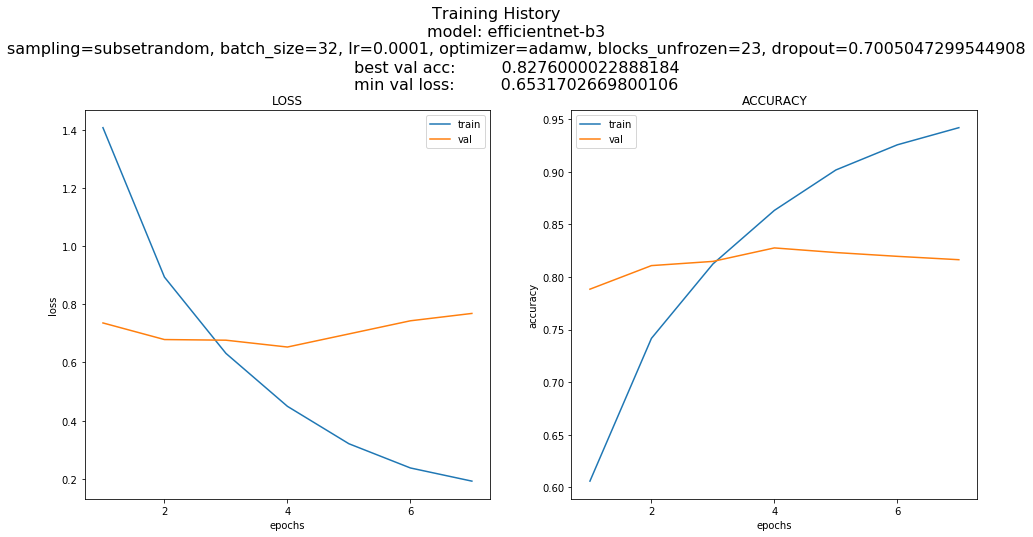

In [5]:
from utils.tester import LocalTester

tester = LocalTester(data=streamingbody,
                     model_loading_params=model_loading_params,
                     model_weights='min_val_loss',
                     show_history=True)

### Model Testing

This shall take around 20 minutes depending on the instance memory and batch size.

*Note: since we were testing locally on a ml.t2.medium, we will use a small batch size to avoid MemoryError*

In [6]:
# tester.to_model('best_acc')  # Uncomment to use `best_acc` model
tester.run(batch_size=20)  # Use a small batch size to avoid MemoryError on a ml.t2.medium

Start evaluating model on test data...
10 / 157 batch of test data evaluated
20 / 157 batch of test data evaluated
30 / 157 batch of test data evaluated
40 / 157 batch of test data evaluated
50 / 157 batch of test data evaluated
60 / 157 batch of test data evaluated
70 / 157 batch of test data evaluated
80 / 157 batch of test data evaluated
90 / 157 batch of test data evaluated
100 / 157 batch of test data evaluated
110 / 157 batch of test data evaluated
120 / 157 batch of test data evaluated
130 / 157 batch of test data evaluated
140 / 157 batch of test data evaluated
150 / 157 batch of test data evaluated
Evaluation ends.
TEST ACC: 0.8194622279129321


To visualize the results, we will call on `confusion_matrix`

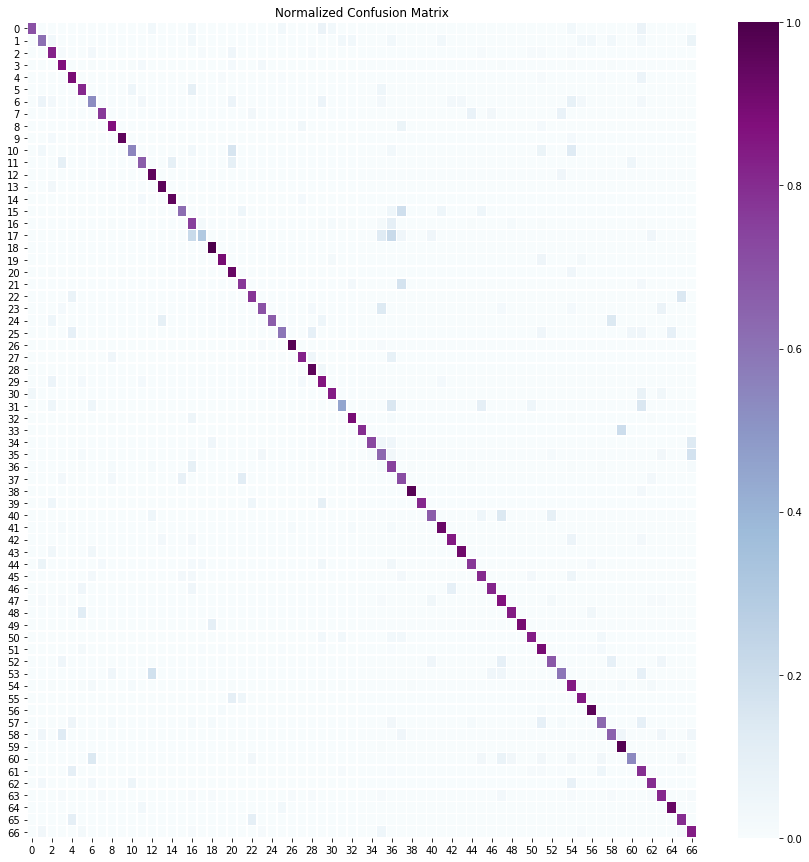

In [7]:
# default normalize and plot; you can set `normalized=False, show=False` to see the raw confusion matrix
tester.confusion_matrix()
# tester.confusion_matrix(normalized=False, show=False)  # raw confusion matrix

We can also find the number of *K* classes with the highest (or lowest) accuracy by calling `top_k` (or `bottom_k`)

In [8]:
tester.top_k(10, metric='recall')  # Change number (1- 67) & metric : `precision` or `recall` or `f1-score`

,recall
category,
florist,1.000000
inside_subway,0.978022
pantry,0.974026
poolinside,0.971429
laundromat,0.963636
closet,0.962963
kindergarden,0.960000
gym,0.956522
computerroom,0.956522


In [9]:
tester.bottom_k(10, metric='recall')  # Change number (1- 67) & metric : `precision` or `recall` or `f1-score`

,recall
category,
fastfood_restaurant,0.304348
lobby,0.450000
museum,0.529412
artstudio,0.535714
trainstation,0.548387
children_room,0.590909
office,0.590909
jewelleryshop,0.612903
concert_hall,0.619048


To evaluate the model using `precision`, `recall` and `f1-score` of each class, we can call on `report` which show `sklearn.metrics.classification_report` as a `pandas.DataFrame`

In [10]:
tester.report()

,precision,recall,f1-score,support
0,0.954545,0.700000,0.807692,30.000000
1,0.612903,0.612903,0.612903,31.000000
2,0.814286,0.826087,0.820144,69.000000
3,0.880000,0.871287,0.875622,101.000000
4,0.836879,0.893939,0.864469,132.000000
...,...,...,...,...
65,0.727273,0.800000,0.761905,20.000000
66,0.781609,0.839506,0.809524,81.000000
accuracy,0.819462,0.819462,0.819462,0.819462
macro avg,0.815625,0.790397,0.798326,3124.000000


In [11]:
tester.report(averaged=True)  # Only show the overall / averaged metrics

,precision,recall,f1-score,support
accuracy,0.819462,0.819462,0.819462,0.819462
macro avg,0.815625,0.790397,0.798326,3124.000000
weighted avg,0.822433,0.819462,0.818138,3124.000000


### Reading Training (and Evaluation) Summary - for report writing

***This part is for reading summaries and report writing purpose***

In [1]:
import sys
import os
sys.path.append('../source')
from utils.tester import Summaries
from sagemaker.s3 import S3Downloader
from sagemaker.session import Session

In [2]:
# Model loading parameters

downloader = S3Downloader()  # downloader class
session = Session()
bucket = session.default_bucket()

# model_uri
efficientnet = 'efficientnet-b3'
training_job = 'efficientnet-b3-hpo-1128-125011-008-f93ecaee'  # Change training job name
model_uri = os.path.join('s3://', bucket, 'mit_indoor_67', training_job, 'output/model.tar.gz')

# local_path
local_path = os.path.join('..', 'models', efficientnet)

if not os.path.exists(local_path):
    os.mkdir(local_path)

# model summary
model_summaries = os.path.join(local_path, training_job)

# `model_loading_params` dictionary to instantiate the tester class    
model_loading_params = dict(downloader=downloader,  # S3 Downloader
                            model_uri=model_uri,  # Model S3 uri
                            local_path=local_path,  # local dir to store model artefacts
                            session=session,  # sagemaker session
                            training_job=training_job  # training job name
                           )

In [3]:
model_summaries = Summaries(model_loading_params=model_loading_params,
                            model_weights='min_val_loss',
                            summary_path=model_summaries)

Loading model.
model_info: {'model': 'efficientnet-b3', 'num_classes': 67, 'blocks_unfrozen': 23, 'dropout': 0.7005047299544908, 'depth': 1}
Loaded pretrained weights for efficientnet-b3
Done loading model.


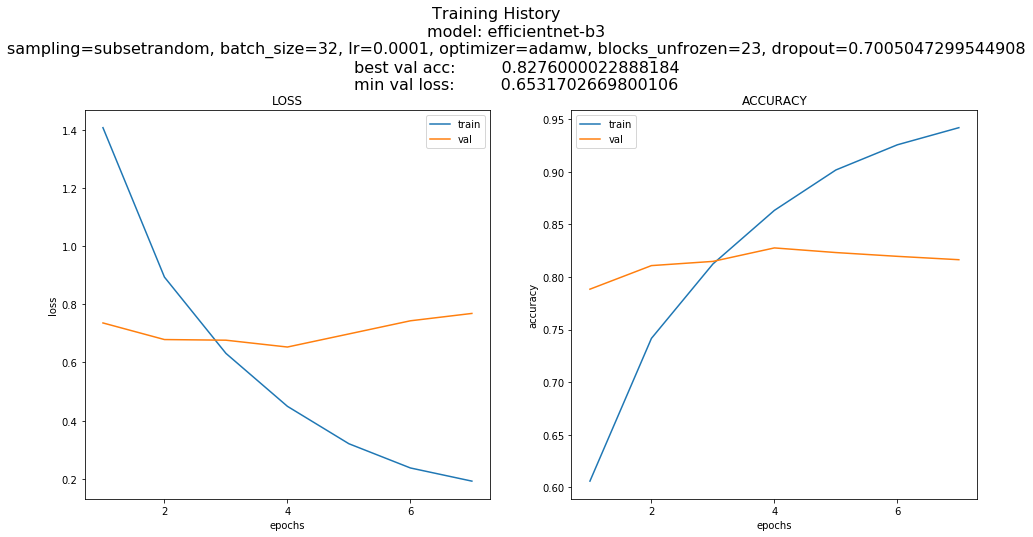

In [4]:
model_summaries.training_history()

In [5]:
model_summaries.top_k(10, metric='f1-score')

,f1-score
category,
pantry,0.974026
bowling,0.964706
poolinside,0.957746
gym,0.956522
inside_subway,0.951872
greenhouse,0.947368
laundromat,0.938053
cloister,0.936170
winecellar,0.934579


In [6]:
model_summaries.bottom_k(10, metric='f1-score')

,f1-score
category,
fastfood_restaurant,0.378378
lobby,0.500000
museum,0.545455
deli,0.600000
jewelleryshop,0.612903
trainstation,0.629630
auditorium,0.649351
office,0.650000
shoeshop,0.652174


In [7]:
model_summaries.report(averaged=True)

,precision,recall,f1-score,support
accuracy,0.819462,0.819462,0.819462,0.819462
macro avg,0.815625,0.790397,0.798326,3124.000000
weighted avg,0.822433,0.819462,0.818138,3124.000000


### Export to ONNX

In [1]:
import sys
import os
sys.path.append('../source')
import torch
from dataset.ENindoor67 import Composer
efficientnet = 'efficientnet-b3'
training_job = 'efficientnet-b3-hpo-1128-125011-008-f93ecaee'  # Change training job name
local_path = os.path.join('..', 'models', efficientnet)

if not os.path.exists(local_path):
    os.mkdir(local_path)

batch_size = 1
resolution = Composer.resolutions()[efficientnet]
input_dummy = torch.randn(batch_size, 3, resolution, resolution, requires_grad=True)
model_path = os.path.join(local_path, training_job, 'model.pth')
model_info = os.path.join(local_path, training_job, 'model_info.pth')
onnx_path = os.path.join(local_path, training_job, '{}.onnx'.format(training_job))

In [2]:
weights = torch.load(model_path, map_location='cpu')
model_info = torch.load(model_info, map_location='cpu')

In [3]:
from model import ModelMaker
net, _ = ModelMaker().make_model(**model_info)
net.load_state_dict(weights)
net.model.set_swish(memory_efficient=False)

Loaded pretrained weights for efficientnet-b3


In [4]:
torch.onnx.export(net, input_dummy, onnx_path, verbose=True, export_params=True)

graph(%input.1 : Float(1:270000, 3:90000, 300:300, 300:1),
      %model._conv_stem.weight : Float(40:27, 3:9, 3:3, 3:1),
      %model._bn0.weight : Float(40:1),
      %model._bn0.bias : Float(40:1),
      %model._bn0.running_mean : Float(40:1),
      %model._bn0.running_var : Float(40:1),
      %model._blocks.0._depthwise_conv.weight : Float(40:9, 1:9, 3:3, 3:1),
      %model._blocks.0._bn1.weight : Float(40:1),
      %model._blocks.0._bn1.bias : Float(40:1),
      %model._blocks.0._bn1.running_mean : Float(40:1),
      %model._blocks.0._bn1.running_var : Float(40:1),
      %model._blocks.0._se_reduce.weight : Float(10:40, 40:1, 1:1, 1:1),
      %model._blocks.0._se_reduce.bias : Float(10:1),
      %model._blocks.0._se_expand.weight : Float(40:10, 10:1, 1:1, 1:1),
      %model._blocks.0._se_expand.bias : Float(40:1),
      %model._blocks.0._project_conv.weight : Float(24:40, 40:1, 1:1, 1:1),
      %model._blocks.0._bn2.weight : Float(24:1),
      %model._blocks.0._bn2.bias : Float(24:1